### Importing Necessary Libraries and Configuring Device

In this cell:
- **Imports**: We import core libraries necessary for building and testing deep learning models, including `torch` for model development, `tqdm` for progress bars, `torchvision` for dataset transformations, and `matplotlib` for visualization.
- **Error Handling**: Each import statement is wrapped in a `try-except` block to provide clear feedback if any library is missing. This ensures the environment setup is validated before proceeding.
- **Device Configuration**: We check for GPU availability and set the device accordingly, enabling efficient computation during model training and inference.


In [ ]:
# Import necessary libraries with enhanced error handling and setup for production use

try:
    import torch
    from torch import nn
    from tqdm.auto import tqdm
    from torchvision import transforms
    from torchvision.utils import make_grid
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    from PIL import Image
except ImportError as e:
    raise ImportError(f"An error occurred while importing libraries: {e}. Please ensure all libraries are installed.")

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/home/arya2004/anaconda3/envs/aicp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Function: show_tensor_images

The `show_tensor_images` function displays a grid of images from a tensor. This function is particularly useful for visualizing a batch of images during model training or evaluation. Key aspects of the function include:

- **Arguments**:
  - `image_tensor`: The input tensor containing a batch of images.
  - `num_images`: The number of images to display. The default is set to 25 images.
  - `size`: The expected dimensions of each image, provided as `(channels, height, width)`. This is used to reshape the tensor appropriately.

- **Process**:
  - **Detachment and CPU Transfer**: `image_tensor` is detached from the computation graph and moved to CPU to prepare it for visualization.
  - **Reshaping**: The function reshapes `image_tensor` into the specified size format.
  - **Image Grid Creation**: A grid of images is created using `torchvision.utils.make_grid` with 5 images per row.
  - **Plotting**: The grid is displayed using `matplotlib`, with axis labels turned off for a clean look.

- **Error Handling**: The function includes a `try-except` block to provide feedback if any errors occur during the visualization process.
  



In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    """
    Displays a grid of images from a given tensor.

    Args:
        image_tensor (torch.Tensor): The input tensor containing image data.
        num_images (int): Number of images to display in the grid.
        size (tuple): Shape of each image in the form (channels, height, width).

    Returns:
        None
    """
    try:
        # Detach the tensor, move to CPU, and reshape based on the provided size
        image_unflat = image_tensor.detach().cpu().view(-1, *size)

        # Create a grid of images with specified number of images per row
        image_grid = make_grid(image_unflat[:num_images], nrow=5, normalize=True)

        # Plot the image grid
        plt.figure(figsize=(10, 10))
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis("off")
        plt.show()

    except Exception as e:
        raise RuntimeError(f"An error occurred while displaying the tensor images: {e}")


### U-Net Model Components for Image Processing

This cell defines the U-Net architecture components in a modular manner, including crop functionality and encoding/decoding blocks. Here’s a breakdown:

- **Crop Function**: This function centers and crops the input image tensor to match the target shape. It includes error handling for better robustness.

#### Contracting Block
- **Purpose**: Downsamples input while doubling the feature channels using convolutional layers. Includes optional batch normalization and dropout for regularization.
- **Error Handling**: Integrated try-except in `crop` to handle potential shape mismatches during cropping.

#### Expanding Block
- **Purpose**: Upsamples and concatenates with corresponding encoder feature maps. Reconstructs image features while reducing channels.
- **Options**: Supports optional batch normalization and dropout layers.
  
#### FeatureMapBlock
- **Purpose**: Acts as a lightweight 1x1 convolution to adjust feature map channels at input/output layers.

#### UNet Class
- **Architecture**: Combines `ContractingBlock` and `ExpandingBlock` layers, creating the classic U-Net structure. The `forward` method enables encoder-decoder flow for input images.
- **Output Layer**: Applies sigmoid activation, standard in segmentation tasks, to normalize outputs between 0 and 1.




In [ ]:
# U-NET

def crop(image, new_shape):
    """
    Crops the input tensor 'image' to match the specified 'new_shape' dimensions.
    
    Args:
        image (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
        new_shape (torch.Size): Target shape for cropping in the form (batch_size, channels, height, width).

    Returns:
        torch.Tensor: Cropped tensor with dimensions matching 'new_shape'.
    """
    try:
        middle_height = image.shape[2] // 2
        middle_width = image.shape[3] // 2
        starting_height = middle_height - round(new_shape[2] / 2)
        final_height = starting_height + new_shape[2]
        starting_width = middle_width - round(new_shape[3] / 2)
        final_width = starting_width + new_shape[3]
        cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
        return cropped_image
    except Exception as e:
        raise RuntimeError(f"Error while cropping image tensor: {e}")

class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.use_bn = use_bn
        self.use_dropout = use_dropout

        # Conditional layers for batch normalization and dropout
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        if use_dropout:
            self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        self.use_bn = use_bn
        self.use_dropout = use_dropout
        self.activation = nn.ReLU()

        # Conditional layers for batch normalization and dropout
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        if use_dropout:
            self.dropout = nn.Dropout()

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        return self.sigmoid(self.downfeature(x12))


### PatchGAN Discriminator

This `Discriminator` class implements the PatchGAN architecture, designed to classify overlapping image patches as real or fake. Each image patch in the final output map corresponds to a local region of the input, making it effective for image-to-image translation tasks. Here’s an overview of the class components:

- **Arguments**:
  - `input_channels`: Defines the number of channels in the input images (e.g., 3 for RGB images).
  - `hidden_channels`: Controls the number of channels in the initial layer, with subsequent layers progressively doubling the channel count.

#### Architecture Components

1. **FeatureMapBlock (upfeature)**: Initial convolutional layer to map the concatenated input into `hidden_channels` feature maps.

2. **Contracting Blocks**:
   - `contract1` to `contract4` progressively downsample the image while doubling the feature count.
   - Batch normalization can be toggled off or on depending on the specific contracting block.

3. **Final Convolution Layer**:
   - Reduces the last layer’s output to a single channel with a 1x1 convolution, providing a scalar prediction per patch.
   - Outputs a map with values indicating the probability that each patch is real or fake.

#### Forward Pass (`forward` method)
- **Concatenation**: The input image (`x`) and condition image (`y`) are concatenated along the channel dimension.
- **Processing**: The concatenated tensor is passed through each feature layer sequentially.
- **Error Handling**: Wraps the forward pass in a try-except block to capture and report any errors during execution.




In [ ]:

# PatchGAN Discriminator
class Discriminator(nn.Module):
    """
    Defines the PatchGAN Discriminator for distinguishing between real and generated images.
    
    Args:
        input_channels (int): Number of input channels for each image (e.g., 3 for RGB).
        hidden_channels (int): Number of channels in the initial hidden layer, which progressively doubles with each block.
    
    Methods:
        forward(x, y): Takes real and generated image pairs, concatenates them, and processes them through the network.
    """
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        
        # Initialize feature layers
        self.upfeature = FeatureMapBlock(input_channels * 2, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        
        # Final layer to output a single-channel prediction map
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        """
        Forward pass that concatenates input image and target image, then processes through discriminator layers.

        Args:
            x (torch.Tensor): The real or generated image tensor with shape (batch_size, channels, height, width).
            y (torch.Tensor): The corresponding condition image tensor (e.g., target or source image).

        Returns:
            torch.Tensor: Single-channel prediction map indicating real/fake likelihood at each patch.
        """
        try:
            # Concatenate the input image and target image along the channel dimension
            x = torch.cat([x, y], axis=1)
            
            # Process concatenated images through PatchGAN layers
            x0 = self.upfeature(x)
            x1 = self.contract1(x0)
            x2 = self.contract2(x1)
            x3 = self.contract3(x2)
            x4 = self.contract4(x3)
            xn = self.final(x4)
            
            return xn
        
        except Exception as e:
            raise RuntimeError(f"An error occurred during the forward pass of the Discriminator: {e}")


### Training Parameters and Configuration

This cell defines and validates the main training parameters for the GAN model, ensuring clear definitions and error handling. Here’s a breakdown of each parameter:

- **Loss Functions**:
  - `adv_criterion`: Binary cross-entropy with logits loss (`BCEWithLogitsLoss`) for the adversarial loss, commonly used in GANs.
  - `recon_criterion`: L1 loss (`L1Loss`) for reconstruction, which encourages the generator to produce outputs similar to the target.

- **Loss Weighting**:
  - `lambda_recon`: Weight for the reconstruction loss, balancing the generator’s emphasis between realism and fidelity to the target image.

- **Training Hyperparameters**:
  - `n_epochs`: Total number of training epochs.
  - `input_dim` and `real_dim`: Define the number of channels for input and output images, typically 3 for RGB images.
  - `display_step`: Specifies how frequently intermediate results should be displayed, helping monitor training progress.
  - `batch_size`: Number of samples per batch during training.
  - `lr`: The learning rate for the optimizer, controlling the step size for parameter updates.
  - `target_shape`: Specifies the target dimensions for images, ensuring they are resized to a square of `256x256`.

- **Device Configuration**:
  - The `device` variable is set based on hardware availability, using CUDA if a GPU is present. This setup optimizes computation and speeds up training when a compatible GPU is available.




In [ ]:
# Training parameters with production-level validation and handling
try:
    # Loss functions for adversarial and reconstruction losses
    adv_criterion = nn.BCEWithLogitsLoss()  # For adversarial loss in GANs
    recon_criterion = nn.L1Loss()           # For reconstruction loss (L1 loss)

    # Regularization parameter for balancing losses
    lambda_recon = 200                      # Weight of the L1 loss relative to the adversarial loss

    # Hyperparameters
    n_epochs = 20                           # Number of training epochs
    input_dim = 3                           # Number of channels in the input image (e.g., 3 for RGB)
    real_dim = 3                            # Number of channels in the output image (e.g., 3 for RGB)
    display_step = 200                      # Frequency of displaying intermediate results during training
    batch_size = 4                          # Batch size for the DataLoader
    lr = 0.0002                             # Learning rate for the optimizer
    target_shape = 256                      # Target image size (height and width of 256x256)
    
    # Set device, using CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

except Exception as e:
    raise RuntimeError(f"An error occurred while setting training parameters: {e}")


### Transforming Dataset and Loading Images

This cell prepares the dataset by applying transformations to convert images to tensors, enabling PyTorch compatibility for model training. Here’s a breakdown of the components:

- **Transformation**:
  - `transforms.ToTensor()`: Converts images from PIL format to PyTorch tensors, normalizing pixel values between 0 and 1. This is the foundational transformation to prepare images for model training.

- **Dataset Loading**:
  - `datasets.ImageFolder`: Loads images from the specified folder (`"maps"` in this case) and applies the defined transformations to each image.
  
- **Error Handling**:
  - Checks for common issues like an incorrect or missing path (`FileNotFoundError`) and general issues (`Exception`) to ensure clear feedback if the dataset fails to load.
  
- **Output Confirmation**:
  - Prints a message confirming successful dataset loading and the number of images, helping to verify that data has been loaded as expected.



In [ ]:
from torchvision import  datasets

# Transforming dataset (images) to Tensors with production-level handling
try:
    # Define transformation: Converts images to tensors, allowing for further processing if needed
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    ])
    
    # Load dataset with specified transform and error handling for path and data integrity
    dataset_path = "maps"
    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    print(f"Dataset loaded successfully from '{dataset_path}' with {len(dataset)} images.")
    
except FileNotFoundError:
    raise FileNotFoundError(f"The dataset path '{dataset_path}' does not exist. Please check the path.")
except Exception as e:
    raise RuntimeError(f"An error occurred while loading the dataset: {e}")


### Initializing Generator, Discriminator, and Optimizers

This cell initializes the generator and discriminator models, along with their optimizers, with robust handling for loading pre-trained weights or initializing randomly. Here’s an overview:

- **Model Initialization**:
  - `gen`: Initializes the U-Net generator with the specified `input_dim` and `real_dim`.
  - `disc`: Initializes the PatchGAN discriminator, which expects concatenated images as input (e.g., `input_dim + real_dim`).

- **Optimizers**:
  - `gen_opt` and `disc_opt` are both configured with the Adam optimizer and the specified learning rate (`lr`), allowing efficient parameter updates.

- **Weights Initialization**:
  - **Custom Function `weights_init`**: Initializes weights for convolutional layers using a normal distribution (mean 0, standard deviation 0.02) and batch normalization layers (bias 0), following GAN best practices.
  
- **Loading Pre-trained Weights**:
  - If `pretrained` is set to `True`, the script attempts to load pre-trained weights from `pix2pix_15000.pth`. 
  - **Error Handling**: A `try-except` block ensures that if pre-trained weights are missing, an informative message is displayed, and models are initialized randomly.

- **Random Initialization**:
  - If `pretrained` is set to `False` or pre-trained weights are unavailable, the models’ weights are initialized from scratch using `weights_init`.
  



In [ ]:
from torch.optim import Adam

# Initializing generator (U-Net) and discriminator, and setting up their optimizers with error handling
try:
    # Initialize generator and discriminator models
    gen = UNet(input_dim, real_dim).to(device)
    disc = Discriminator(input_dim + real_dim).to(device)

    # Define optimizers
    gen_opt = Adam(gen.parameters(), lr=lr)
    disc_opt = Adam(disc.parameters(), lr=lr)

    def weights_init(m):
        """Initializes weights for convolutional and batch normalization layers."""
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)

    # Load pre-trained weights if available, or initialize weights from scratch
    pretrained = True  # Set this to False if training from scratch
    if pretrained:
        try:
            # Load pre-trained weights
            loaded_state = torch.load("pix2pix_15000.pth", map_location=device)
            gen.load_state_dict(loaded_state["gen"])
            gen_opt.load_state_dict(loaded_state["gen_opt"])
            disc.load_state_dict(loaded_state["disc"])
            disc_opt.load_state_dict(loaded_state["disc_opt"])
            print("Pre-trained weights loaded successfully.")
        except FileNotFoundError:
            print("Pre-trained weights not found. Proceeding with random initialization.")
            pretrained = False
    if not pretrained:
        # Apply custom weights initialization
        gen.apply(weights_init)
        disc.apply(weights_init)
        print("Weights initialized from scratch.")
    
except Exception as e:
    raise RuntimeError(f"An error occurred during model initialization: {e}")


### Generator Loss Calculation: `get_gen_loss`

The `get_gen_loss` function calculates the generator’s total loss, combining adversarial and reconstruction losses to encourage both realistic and accurate image generation. Here’s an overview of the function components:

- **Arguments**:
  - `gen` and `disc`: The generator and discriminator models.
  - `real`: Real target images for comparison with generated images.
  - `condition`: Condition images provided as input to the generator.
  - `adv_criterion`: Adversarial loss function, often `BCEWithLogitsLoss`.
  - `recon_criterion`: Reconstruction loss function, typically `L1Loss`.
  - `lambda_recon`: Weight factor for balancing adversarial and reconstruction losses.

#### Process

1. **Generate Fake Images**:
   - `gen(condition)`: The generator creates fake images based on the `condition` input.

2. **Discriminator Output**:
   - The discriminator (`disc`) evaluates the fake images against the condition to calculate the adversarial loss component.

3. **Adversarial Loss Calculation**:
   - `adv_loss`: Measures the generator’s ability to “fool” the discriminator by labeling all patches as real. A tensor of ones (`torch.ones_like(disc_out)`) represents the target labels for real images, aligning with the generator’s goal.

4. **Reconstruction Loss Calculation**:
   - `recon_loss`: Measures the similarity between the generated images and the real images using `L1Loss`, encouraging fidelity to the original target image.

5. **Combined Loss**:
   - `gen_loss`: The total loss is a weighted sum of the adversarial and reconstruction losses, controlled by `lambda_recon`.

#### Error Handling
- The function includes a `try-except` block to capture and report any issues, ensuring robust execution during training.



In [ ]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    """
    Calculates the generator loss, which combines adversarial loss and reconstruction loss.
    
    Args:
        gen (nn.Module): Generator model.
        disc (nn.Module): Discriminator model.
        real (torch.Tensor): Real target images.
        condition (torch.Tensor): Conditional input images for the generator.
        adv_criterion (nn.Module): Loss function for adversarial loss (e.g., BCEWithLogitsLoss).
        recon_criterion (nn.Module): Loss function for reconstruction loss (e.g., L1Loss).
        lambda_recon (float): Weight factor for reconstruction loss.

    Returns:
        torch.Tensor: Combined generator loss.
    """
    try:
        # Generate fake images using the generator
        fake_images = gen(condition)

        # Discriminator output for fake images
        disc_out = disc(fake_images, condition)

        # Move adversarial criterion to the correct device
        adv_criterion = adv_criterion.to(fake_images.device)

        # Calculate adversarial loss with real labels (targeting ones to "fool" the discriminator)
        adv_loss = adv_criterion(disc_out, torch.ones_like(disc_out, device=fake_images.device))

        # Calculate reconstruction loss
        recon_loss = recon_criterion(fake_images, real)

        # Calculate total generator loss as a weighted sum of adversarial and reconstruction losses
        gen_loss = adv_loss + lambda_recon * recon_loss

        return gen_loss

    except Exception as e:
        raise RuntimeError(f"An error occurred while calculating generator loss: {e}")


### Training Function for GAN Model

This cell defines the `train` function, which handles the main training loop for the GAN model, including updating the generator and discriminator, logging, and saving model checkpoints.

#### Key Components

- **Arguments**:
  - `save_model`: If set to `True`, the model’s weights and optimizers are saved at each display step.

#### Training Loop

1. **Data Preparation**:
   - The dataloader iterates over batches, with each batch split into `condition` (left half) and `real` (right half) images.
   - Images are resized to the target shape (`target_shape`) and moved to the device.

2. **Discriminator Update**:
   - **Generate Fake Images**: Uses the generator to create `fake` images from `condition`.
   - **Calculate Losses**:
     - **Fake Loss**: Uses `disc` on `fake` images to determine how well it identifies them as fake.
     - **Real Loss**: Uses `disc` on `real` images to assess how well it identifies them as real.
   - **Backward Pass and Optimization**: The discriminator loss is backpropagated and the optimizer step is taken.

3. **Generator Update**:
   - **Loss Calculation**: Calls `get_gen_loss` to calculate the generator’s loss, combining adversarial and reconstruction losses.
   - **Backward Pass and Optimization**: The generator loss is backpropagated and its optimizer step is taken.

4. **Loss Accumulation and Averaging**:
   - The generator and discriminator losses are accumulated and averaged over a set number of steps (`display_step`).

5. **Visualization and Logging**:
   - Periodically displays the generator, discriminator losses, and a sample of `condition`, `real`, and `fake` images for monitoring progress.
   - Logs information for each `display_step` to provide insights into the training process.

6. **Model Checkpointing**:
   - If `save_model` is `True`, saves the model’s weights and optimizers at each `display_step` for future restoration or analysis.


  0%|          | 0/549 [00:00<?, ?it/s]

Pretrained initial state


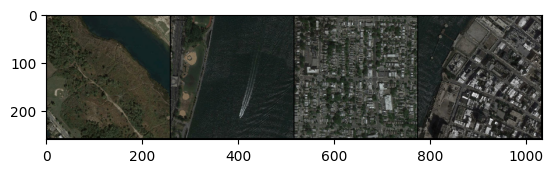

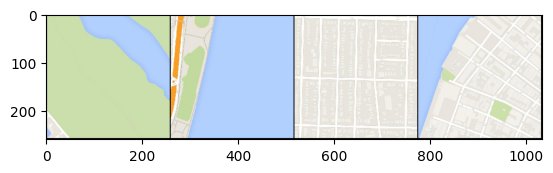

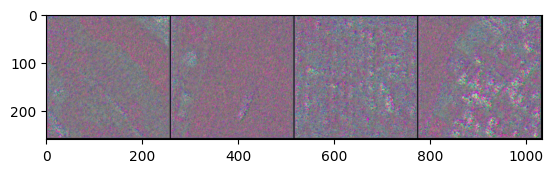

 36%|███▋      | 200/549 [08:40<14:22,  2.47s/it]

Epoch 0: Step 200: Generator (U-Net) loss: 54.48981502532958, Discriminator loss: 0.1872029036469757


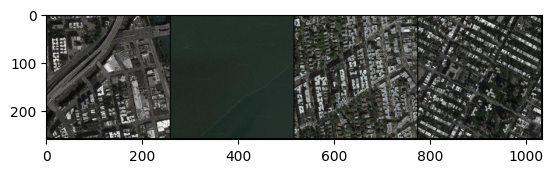

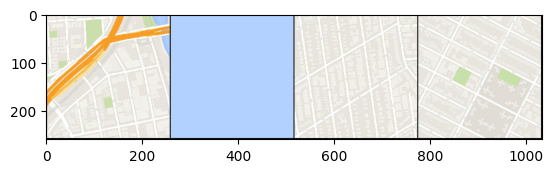

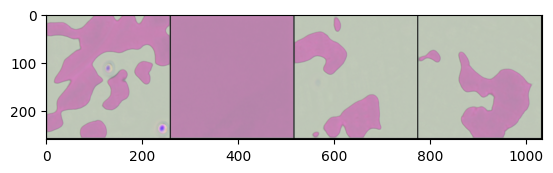

 73%|███████▎  | 400/549 [19:34<08:43,  3.52s/it]

Epoch 0: Step 400: Generator (U-Net) loss: 33.576324434280416, Discriminator loss: 0.033314058007672426


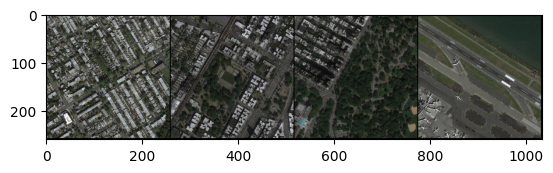

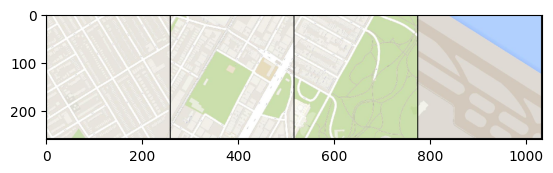

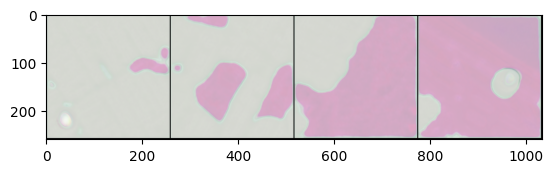

 86%|████████▋ | 474/549 [24:13<03:50,  3.07s/it]


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Training Function

def train(save_model=False):
    """
    Trains the GAN model with the specified generator and discriminator.
    
    Args:
        save_model (bool): If True, saves the model checkpoint at each display step.

    Returns:
        None
    """
    try:
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        cur_step = 0

        for epoch in range(n_epochs):
            print(f"Starting epoch {epoch + 1}/{n_epochs}")
            
            for image, _ in tqdm(dataloader):
                # Split image into condition (left half) and real (right half)
                image_width = image.shape[3]
                condition = image[:, :, :, :image_width // 2]
                condition = nn.functional.interpolate(condition, size=target_shape)
                real = image[:, :, :, image_width // 2:]
                real = nn.functional.interpolate(real, size=target_shape)

                # Move to device
                condition, real = condition.to(device), real.to(device)
                
                # Update discriminator
                disc_opt.zero_grad()
                with torch.no_grad():
                    fake = gen(condition)
                disc_fake_hat = disc(fake.detach(), condition)
                disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
                disc_real_hat = disc(real, condition)
                disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
                disc_loss = (disc_fake_loss + disc_real_loss) / 2
                disc_loss.backward(retain_graph=True)
                disc_opt.step()

                # Update generator
                gen_opt.zero_grad()
                gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
                gen_loss.backward()
                gen_opt.step()

                # Accumulate losses for averaging
                mean_discriminator_loss += disc_loss.item() / display_step
                mean_generator_loss += gen_loss.item() / display_step

                # Visualization and logging
                if cur_step % display_step == 0:
                    if cur_step > 0:
                        print(f"Epoch {epoch + 1}, Step {cur_step}: "
                              f"Generator loss: {mean_generator_loss:.4f}, "
                              f"Discriminator loss: {mean_discriminator_loss:.4f}")
                    else:
                        print("Initial model state (pre-training)")
                    
                    show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                    show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                    show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                    
                    mean_generator_loss = 0
                    mean_discriminator_loss = 0
                    
                    # Save model checkpoint
                    if save_model:
                        torch.save({
                            'gen': gen.state_dict(),
                            'gen_opt': gen_opt.state_dict(),
                            'disc': disc.state_dict(),
                            'disc_opt': disc_opt.state_dict()
                        }, f"pix2pix_checkpoint_step_{cur_step}.pth")
                        print(f"Model checkpoint saved at step {cur_step}")
                
                cur_step += 1

    except Exception as e:
        raise RuntimeError(f"An error occurred during training: {e}")

# Call the training function with model saving enabled
train(save_model=True)


### Evaluation/Testing of the Trained Generator Model

This cell loads a pre-trained generator model and evaluates it on a single test image to produce and visualize the generated output.

#### Key Steps

1. **Model Loading**:
   - `gen = UNet(input_dim, real_dim).to("cpu")`: Initializes the generator model with the specified input and output dimensions.
   - The pre-trained weights are loaded from `pix2pix_15000.pth`.
   - The model is set to `eval` mode to disable dropout and batch normalization layers, ensuring consistent results.

2. **Image Transformation**:
   - A transformation pipeline is defined to resize the input image to the target shape (`256x256`) and convert it to a PyTorch tensor.

3. **Loading and Preprocessing the Input Image**:
   - Attempts to load the specified test image. If the image path is invalid, a `FileNotFoundError` is raised with a clear message.
   - The image is then transformed, adding a batch dimension for compatibility with the model.

4. **Visualizing the Input Image**:
   - The input image is denormalized (pixel values returned to the 0–1 range) and displayed using `matplotlib`, providing a reference image for comparison.

5. **Generating Output**:
   - With `torch.no_grad()` to disable gradient tracking, the generator creates an output image based on the input.
   - The shape of the output tensor is displayed for verification.

6. **Visualizing the Output Image**:
   - The output tensor is converted to an image format, denormalized, and clamped to ensure pixel values are valid (0–1 range).
   - The generated output is displayed alongside the input image, allowing visual comparison.

#### Error Handling
- **Model and Image Loading**: Includes error handling for missing model weights and invalid image paths.
- **General Error Handling**: Wraps the evaluation process in a `try-except` block to provide informative error messages if any step fails.



/tmp/ipykernel_7560/2283640114.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load("pix2pix_15000.pth", map_location=torch.device('cpu'))


Shape of the input tensor: torch.Size([1, 3, 256, 256])


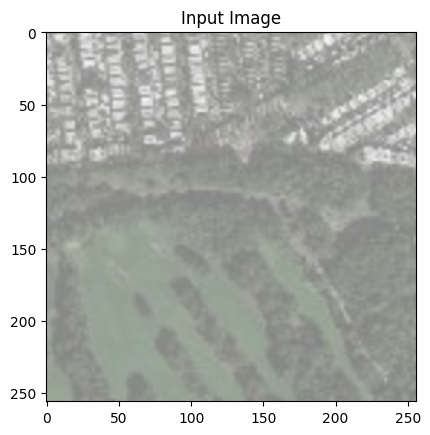

Shape of the output tensor: torch.Size([1, 3, 256, 256])


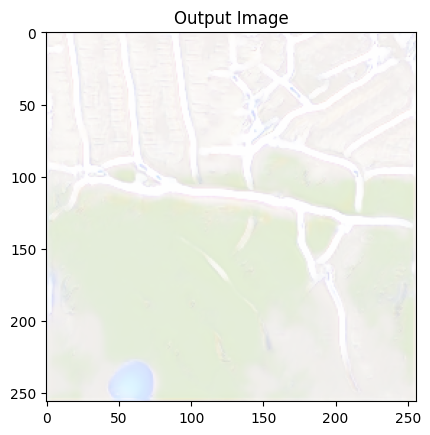

In [ ]:
# Evaluation/Testing setup

input_dim = 3
real_dim = 3
target_shape = 256

try:
    # Load the generator model and weights
    gen = UNet(input_dim, real_dim).to("cpu")
    loaded_state = torch.load("pix2pix_15000.pth", map_location="cpu")
    gen.load_state_dict(loaded_state["gen"])
    gen.eval()  # Set the model to evaluation mode
    print("Model loaded successfully for evaluation.")

    # Define the transformation for the test image
    transform = transforms.Compose([
        transforms.Resize((target_shape, target_shape)),
        transforms.ToTensor()
    ])

    # Load and preprocess the input image
    image_path = "24.jpg"  # Path to the test image
    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        print(f"Shape of the input tensor: {image_tensor.shape}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Image file not found at path: {image_path}")

    # Visualize the input image (denormalized)
    input_image = image_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5  # Denormalize for visualization
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Move image tensor to the device
    image_tensor = image_tensor.to("cpu")

    # Generate the output with the generator
    with torch.no_grad():  # Disable gradient computation
        output = gen(image_tensor)

    print(f"Shape of the output tensor: {output.shape}")

    # Convert the output tensor to an image format and visualize it
    output_image = output.squeeze(0).permute(1, 2, 0).cpu().detach()
    output_image = (output_image * 0.5 + 0.5).clamp(0, 1)  # Denormalize and clamp for valid pixel range

    plt.imshow(output_image)
    plt.title("Output Image")
    plt.axis("off")
    plt.show()

except Exception as e:
    raise RuntimeError(f"An error occurred during evaluation: {e}")
